# Machine Learning  API's with FastAPI

## Business Understanding

***Project Overview***

The objective of this project is to develop a predictive model that identifies ICU patients at risk of developing sepsis. Early identification of such patients can significantly improve treatment outcomes, reduce mortality rates, and lower healthcare costs by enabling timely interventions.

**Key Objectives**
    
`Early Detection:` Predict which patients in the ICU are likely to develop sepsis, allowing healthcare providers to intervene early and improve patient outcomes.

`Resource Allocation: `Optimize the allocation of medical resources by focusing attention and care on high-risk patients.
 
`Cost Reduction:` Reduce healthcare costs associated with sepsis by preventing its occurrence through early interventions.

### Hypothesis

Null Hypothesis(Ho): Older patients (age 60 and above) are less likely to develop sepsis compared to younger patients (below 60 years)

Alternate Hypothesis(Ha): Older patients (age 60 and above) are more likely to develop sepsis compared to younger patients (below 60 years)

### Analytical Questions
1. Is there a relationship between body mass index (M11) and the development of sepsis?
 
2. Are there noticeable differences in blood pressure (PR) readings between sepsis-positive and sepsis-negative patients?
 
3. How do plasma glucose levels (PRG) differ between patients who develop sepsis and those who do not?

4. Does a patient having an Insurance card influence Sepsis development?

5. What is the average/median age of patients who develop sepsis and those without sepsis?

## Data Understanding

### Data Fields

| Column   Name                | Attribute/Target | Description                                                                                                                                                                                                  |
|------------------------------|------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ID                           | N/A              | Unique number to represent patient ID                                                                                                                                                                        |
| PRG           | Attribute1       |  Plasma glucose|
| PL               | Attribute 2     |   Blood Work Result-1 (mu U/ml)                                                                                                                                                |
| PR              | Attribute 3      | Blood Pressure (mm Hg)|
| SK              | Attribute 4      | Blood Work Result-2 (mm)|
| TS             | Attribute 5      |     Blood Work Result-3 (mu U/ml)|                                                                                  
| M11     | Attribute 6    |  Body mass index (weight in kg/(height in m)^2|
| BD2             | Attribute 7     |   Blood Work Result-4 (mu U/ml)|
| Age              | Attribute 8      |    patients age  (years)|
| Insurance | N/A     | If a patient holds a valid insurance card|
| Sepsis                 | Target           | Positive: if a patient in ICU will develop a sepsis , and Negative: otherwise |


#### Importations

In [1]:
# Standard library imports
import os
import warnings 
warnings.filterwarnings('ignore')


# Data manipulation and analysis
import pandas as pd
import numpy as np
import joblib

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical analysis
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, FunctionTransformer, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.exceptions import ConvergenceWarning 

# Feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Machine learning models
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# Imbalanced-learn utilities
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [2]:
# Load train dataset
train_df = pd.read_csv("../Data/Paitients_Files_Train.csv")
train_df.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


### Exploratory Data Analysis (EDA)

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [4]:
# Rename sepsis coloumn
train_df.rename(columns= {'Sepssis':'Sepsis'}, inplace=True)

In [5]:
train_df.isna().sum()


ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepsis       0
dtype: int64

In [6]:
train_df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,599,599,ICU200608,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRG,599.0,NaN,NaN,NaN,3.824708,3.362839,0.0,1.0,3.0,6.0,17.0
PL,599.0,NaN,NaN,NaN,120.153589,32.682364,0.0,99.0,116.0,140.0,198.0
PR,599.0,NaN,NaN,NaN,68.732888,19.335675,0.0,64.0,70.0,80.0,122.0
SK,599.0,NaN,NaN,NaN,20.562604,16.017622,0.0,0.0,23.0,32.0,99.0
TS,599.0,NaN,NaN,NaN,79.460768,116.576176,0.0,0.0,36.0,123.5,846.0
M11,599.0,NaN,NaN,NaN,31.920033,8.008227,0.0,27.1,32.0,36.55,67.1
BD2,599.0,NaN,NaN,NaN,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,NaN,NaN,NaN,33.290484,11.828446,21.0,24.0,29.0,40.0,81.0
Insurance,599.0,NaN,NaN,NaN,0.686144,0.464447,0.0,0.0,1.0,1.0,1.0


In [7]:
train_df.duplicated().sum()

np.int64(0)

### Univariate Analysis

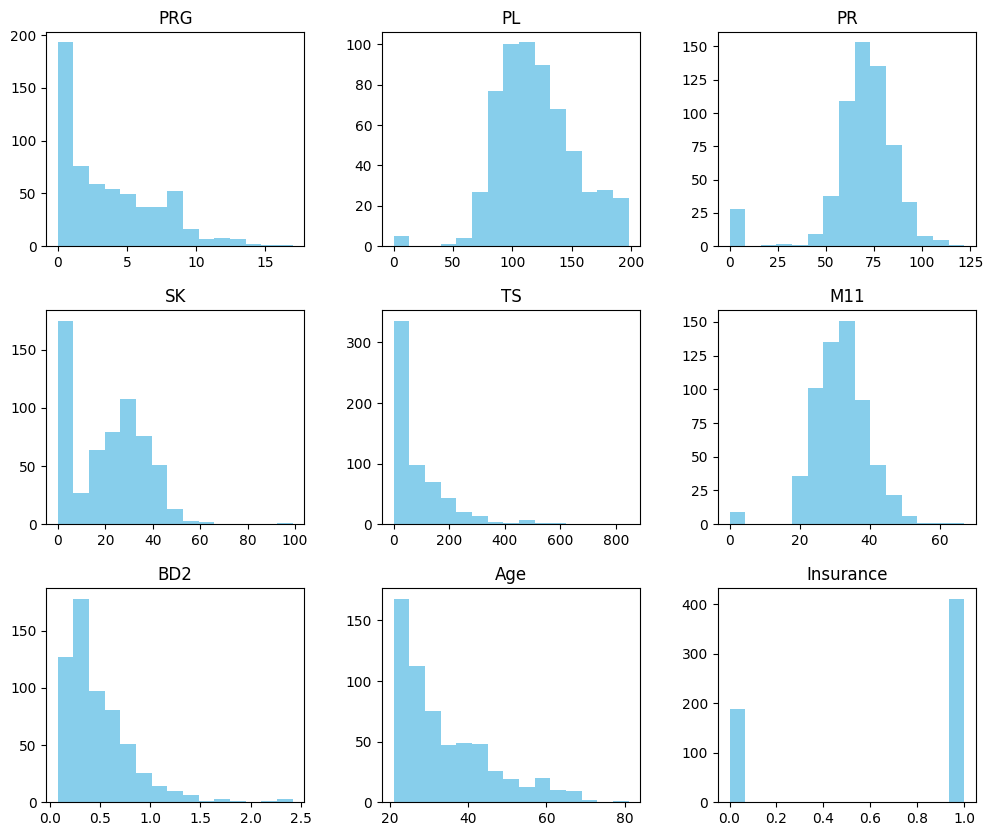

In [8]:
# Histogram showing the distribution of numeric features
train_df.hist(figsize=(12,10), color='skyblue', grid =False , bins =15)
plt.show()

#### **Observations**
- PRG (Plasma Glucose): Highly skewed to the right, with most values below 5.
- PL (Blood Work Result-1): Normally distributed, centered around 100.
- PR (Blood Pressure): Right-skewed, with most values around 70-80 mm Hg.
- SK (Blood Work Result-2): Right-skewed, with most values under 20.
- TS (Blood Work Result-3): Highly right-skewed, with most values below 200.
- M11 (BMI): Approximately normally distributed, centered around 30.
- BD2 (Blood Work Result-4): Highly right-skewed, with most values below 0.5.
- Age: left-skewed, with most patients aged 20-40.
- Insurance: Bimodal distribution, indicating two distinct groups (with and without insurance), with more patients holding insurance.

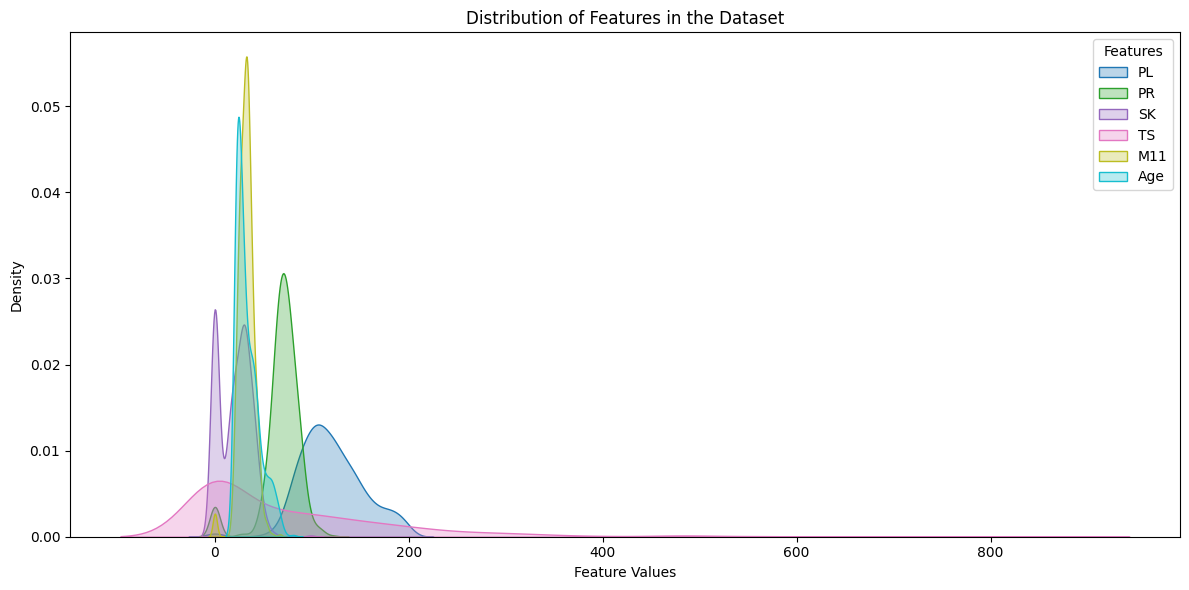

In [9]:
cols_to_plot = train_df.drop(['ID','BD2', 'PRG', 'Insurance', 'Sepsis'], axis=1).columns
plt.figure(figsize=(12,6))

# Create a colormap object for assigning different colors
 
cmap = plt.get_cmap('tab10')
num_colors = len(cols_to_plot)
 
for i, col in enumerate(cols_to_plot):

    #Generate color based on index and number of colors 
    color = cmap(i / (num_colors - 1))

    #Create the KDE plot for each feature on top of the histogram 
    sns.kdeplot(train_df[col], fill=True, color = color, alpha=0.3, label=col)
 
# Adjust plot elements
 
plt.xlabel('Feature Values') 
plt.ylabel('Density')
plt.title('Distribution of Features in the Dataset') 
plt.legend(title='Features') 
plt.tight_layout()
 
plt.show()

These distributions suggest that the majority of feature values are clustered at lower ranges, with some features having a few higher values.

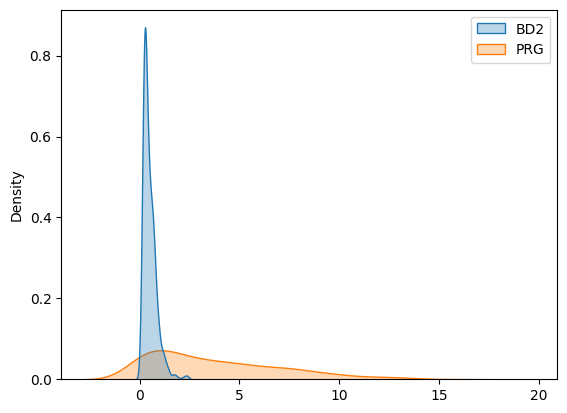

In [10]:
col = train_df[['BD2', 'PRG']]
sns.kdeplot(col, fill=True, color=color, alpha=0.3, label=col)
plt.show()

In [11]:
# sns.kdeplot(train_df.drop('Sepsis', axis=1).values.ravel())

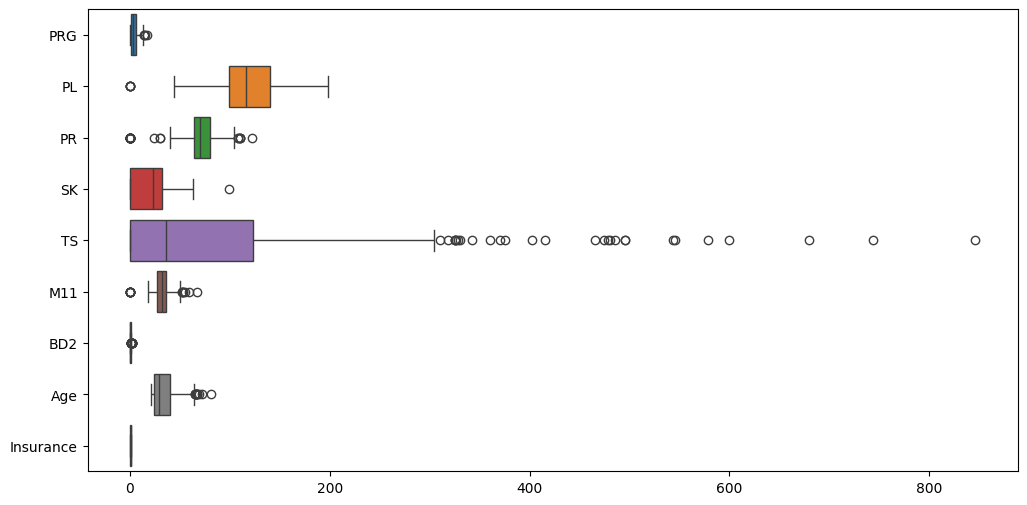

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df.drop(['ID', 'Sepsis'], axis=1), orient='h')
plt.show()

#### Observations
- TS(Blood Work Result-3) stands out with a wide range and numerous outliers, indicating significant variability.
- PL(Blood Work Result-1) and Age also show moderate dispersion and outliers. 
- Other features, such as PRG and BD2, have smaller ranges and fewer outliers.

### Bivariate Analysis

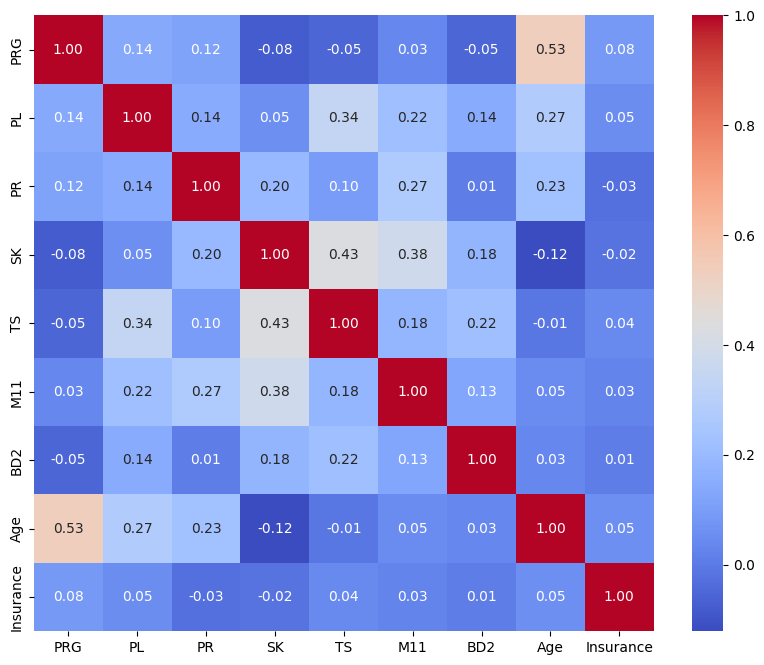

In [13]:
numeric_features = train_df.select_dtypes('number').columns
cor = train_df[numeric_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(cor, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### **Key Insights**
1. **Strongest Positive Correlations**:
   - **Age and PRG (0.53)**: Older patients tend to have higher plasma glucose levels.
   - **PL and TS (0.34)**: These two blood work results are moderately correlated.
   - **SK and TS (0.43)**: These two blood work results also show a moderate correlation.

2. **Weak to No Correlations**:
   - **Insurance**: Very weak correlations with all other variables.
   - **BD2**: Very weak correlations with other variables, indicating it is relatively independent.

3. **Other Notable Correlations**:
   - **PL and M11 (0.22)**: Some correlation between blood work result PL and BMI.
   - **PR and M11 (0.27)**: Blood pressure and BMI are somewhat correlated.

Most variables exhibit weak correlations, suggesting they are largely independent of each other. The notable exceptions are the moderate correlations among certain blood work results and between age and plasma glucose levels.

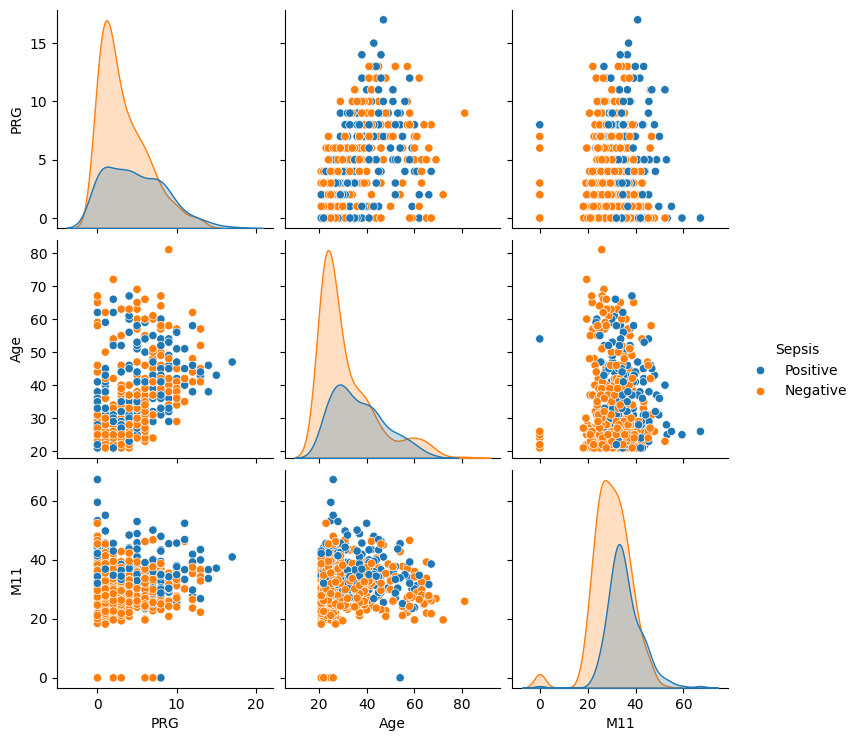

In [14]:
cols_to_use = train_df[['PRG', 'Age', 'M11', 'Sepsis']]
sns.pairplot(cols_to_use, hue='Sepsis')
plt.show()

#### **Key Insights**
This pair plot visualizes the relationships between PRG (Plasma Glucose), Age, and M11 (BMI) for patients categorized by sepsis status:

1. **PRG vs. Age**: Positive sepsis cases (blue) tend to have higher plasma glucose levels than negative cases (orange), especially noticeable in younger patients.
2. **PRG vs. M11**: There is no clear separation between sepsis-positive and sepsis-negative cases based on BMI and plasma glucose levels.
3. **Age vs. M11**: Younger patients with lower BMI appear more likely to develop sepsis, while older patients show a mix of outcomes.
4. **Distributions**:
    - **PRG**: Higher plasma glucose levels are more common in sepsis-positive cases.
    - **Age**: Sepsis-positive cases are spread across a wider age range compared to negative cases.
    - **M11**: The BMI distribution is similar for both sepsis-positive and sepsis-negative cases, with a slight shift towards higher BMI in sepsis-negative cases.

Overall, higher plasma glucose levels and lower BMIs in younger patients might be associated with sepsis development.

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepsis     599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


#### **Hypothesis**

In [16]:
train_df['Age_group'] = train_df['Age'].apply(lambda x: '60 and above' if x >= 60 else 'below 60')
 
contingency_table = pd.crosstab(train_df['Age_group'], train_df['Sepsis']) 

print(contingency_table)
  
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table) 
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")

Sepsis        Negative  Positive
Age_group                       
60 and above        20         7
below 60           371       201
Chi-square statistic: 0.601967563891041
p-value: 0.43782829453541183


In [17]:
if p < 0.01:     
       print("We reject the Null Hypothesis: There is a significant association between age group and sepsis outcome.")
else:     
     print("There is no significant association between age group and sepsis outcome.")

There is no significant association between age group and sepsis outcome.


#### Key Analytical Insights

The chi-square test results support the conclusion that there is no significant association between the age group and the sepsis outcome in the given dataset. This implies that age, in this specific categorization, is not a decisive factor in sepsis outcomes based on the provided dataset.

- Body Mass Index (BMI) and Sepsis: There is a noticeable relationship between BMI and the development of sepsis, with sepsis-positive patients having a higher average BMI.

- Plasma Glucose Levels (PRG): Sepsis-positive patients have higher mean and median plasma glucose levels compared to sepsis-negative patients, indicating a potential biomarker for sepsis risk.

- Blood Pressure (PR): Differences in blood pressure readings between sepsis-positive and sepsis-negative patients may also provide predictive insights.

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepsis     599 non-null    object 
 11  Age_group  599 non-null    object 
dtypes: float64(2), int64(7), object(3)
memory usage: 56.3+ KB


### **Answering Analytical Questions**

QN 1. Is there a relationship between body mass index (M11) and the development of sepsis?

          count       mean       std  min     25%   50%     75%   max
Sepsis                                                               
Negative  391.0  30.076471  7.812732  0.0  25.200  29.9  35.050  52.3
Positive  208.0  35.385577  7.195898  0.0  30.975  34.3  39.025  67.1


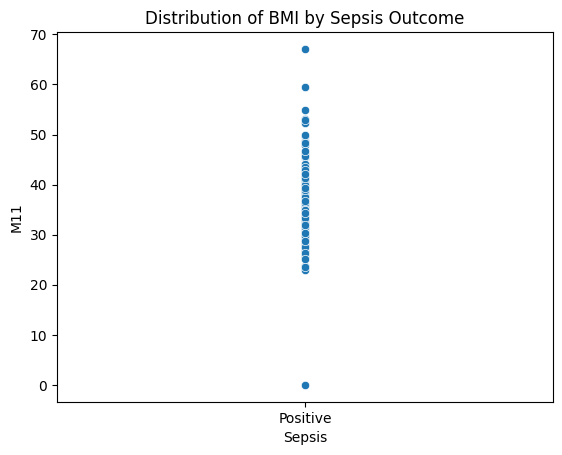

In [19]:
# Summary statistics
print(train_df.groupby('Sepsis')['M11'].describe()) 
# Boxplot
sns.scatterplot(x='Sepsis', y='M11', data=train_df[train_df['Sepsis']=='Positive']) 
plt.title('Distribution of BMI by Sepsis Outcome') 
plt.show()

#### Observation
The statistics indicate that there is a notable difference in the BMI between patients who developed sepsis and those who did not. On average, patients who developed sepsis tend to have a higher BMI. This suggests a potential relationship between higher BMI and the development of sepsis.

The data points are concentrated around typical BMI values, with most falling between 20 and 40. There are a few outliers, including one very low BMI near 0 and several high BMIs above 50. This suggests that while most individuals with a positive sepsis outcome have BMIs within a normal to moderately high range, there are exceptional cases with very low or very high BMIs.

QN 2. Are there noticeable differences in blood pressure (PR) readings between sepsis-positive and sepsis-negative patients?

          count       mean        std  min   25%   50%   75%    max
Sepsis                                                             
Negative  391.0  67.872123  17.917733  0.0  62.0  70.0  78.0  122.0
Positive  208.0  70.350962  21.706360  0.0  66.0  74.0  82.0  110.0


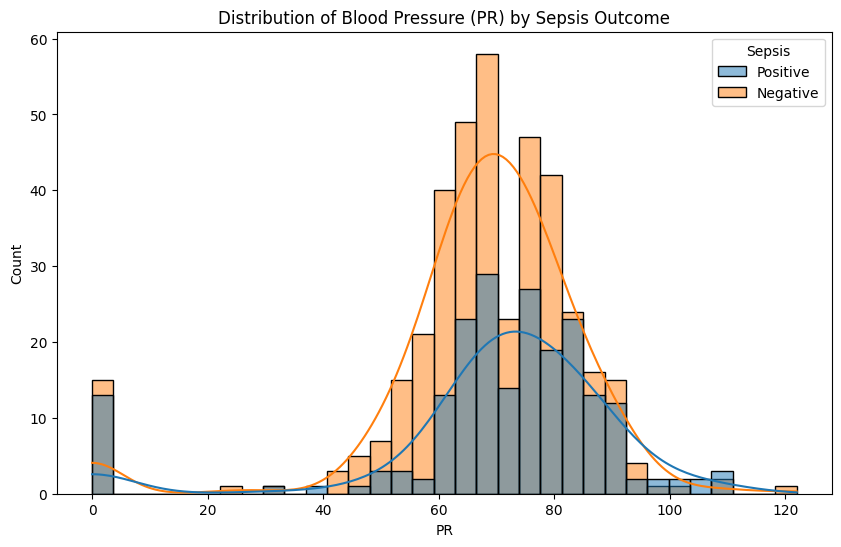

Mann-Whitney U test p-value: 0.0005014049708706393
There are noticeable differences in Blood Pressure(PR) readings between sepsis-positive and sepsis-negative patients


In [20]:
# Calculate summary statistics
summary_stats = train_df.groupby('Sepsis')['PR'].describe()
print(summary_stats)
 
# Histogram
plt.figure(figsize=(10,6))
sns.histplot(data=train_df, x='PR', hue='Sepsis', kde=True) 
plt.title('Distribution of Blood Pressure (PR) by Sepsis Outcome')
plt.show()
  
# Extract PR values for each group
sepsis_positive = train_df[train_df['Sepsis'] == 'Positive']['PR']
sepsis_negative = train_df[train_df['Sepsis'] == 'Negative']['PR']
 
u_stat, p_value = mannwhitneyu(sepsis_positive, sepsis_negative)
print(f"Mann-Whitney U test p-value: {p_value}")

if p < 0.01:     
       print("There are no noticeable differences in Blood Pressure(PR) readings between sepsis-positive and sepsis-negative patients")
else:     
     print("There are noticeable differences in Blood Pressure(PR) readings between sepsis-positive and sepsis-negative patients")
 

#### Observations
- The distributions for both groups are roughly bell-shaped, with the negative sepsis group peaking around 65 PR and the positive sepsis group peaking around 75 PR. 

- There is a higher concentration of negative sepsis cases at lower blood pressure values (around 60 PR) compared to positive sepsis cases. 

- Conversely, positive sepsis cases are more frequent at higher blood pressure values. This indicates a potential correlation between higher blood pressure and positive sepsis outcomes.

Qn 3. How do plasma glucose levels (PRG) differ between patients who develop sepsis and those who do not?

          count      mean       std  min   25%  50%  75%   max
Sepsis                                                        
Negative  391.0  3.317136  3.018182  0.0  1.00  2.0  5.0  13.0
Positive  208.0  4.778846  3.755722  0.0  1.75  4.0  8.0  17.0


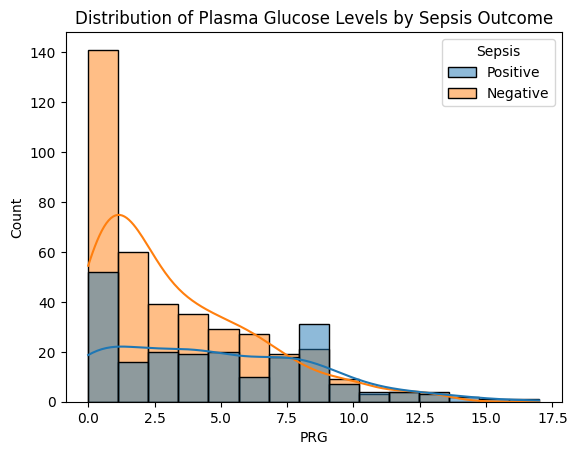

Mann-Whitney U test p-value: 7.517335229649623e-06
There are noticeable differences in Blood Pressure(PR) readings between sepsis-positive and sepsis-negative patients


In [21]:
# Summary statistics
print(train_df.groupby('Sepsis')['PRG'].describe())
 
# Histogram
sns.histplot(data=train_df, x='PRG', hue='Sepsis', kde=True)
plt.title('Distribution of Plasma Glucose Levels by Sepsis Outcome')
plt.show()
 
sepsis_positive_prg = train_df[train_df['Sepsis'] == 'Positive']['PRG']
sepsis_negative_prg = train_df[train_df['Sepsis'] == 'Negative']['PRG']
 
u_stat, p_value = mannwhitneyu(sepsis_positive_prg, sepsis_negative_prg)
print(f"Mann-Whitney U test p-value: {p_value}")

if p < 0.01:     
       print("There are no noticeable differences in Blood Pressure(PR) readings between sepsis-positive and sepsis-negative patients")
else:     
     print("There are noticeable differences in Blood Pressure(PR) readings between sepsis-positive and sepsis-negative patients")

#### Observations
Statistical

- Mean PRG: Sepsis-positive patients have a higher mean plasma glucose level (4.78) compared to sepsis-negative patients (3.32).

- Median PRG: The median plasma glucose level is higher for sepsis-positive patients (4.0) than for sepsis-negative patients (2.0).

- Interquartile Range (IQR): The IQR for sepsis-positive patients (1.75 - 8.0) is higher than for sepsis-negative patients (1.00 - 5.0).

- Standard Deviation (Std): Sepsis-positive patients show a higher standard deviation (3.76) compared to sepsis-negative patients (3.02), indicating greater variability in plasma glucose levels among sepsis-positive patients.

Visualization

- The distribution for the negative sepsis group is heavily skewed towards lower glucose levels, with a significant peak at 0-2.5 PRG.

- In contrast, the positive sepsis group shows a more even spread across different glucose levels, with a noticeable peak around 10 PRG. This suggests that lower plasma glucose levels are more commonly associated with negative sepsis outcomes, while higher glucose levels may be indicative of positive sepsis outcomes.

Qn4. Does a patient having an Insurance card influence Sepsis development? 

In [22]:
insurance_sepsis = train_df.groupby('Sepsis')['Insurance'].sum()

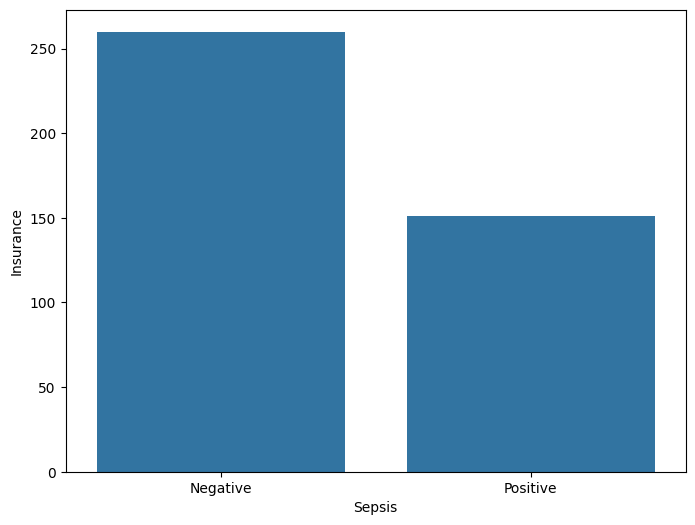

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(insurance_sepsis)
plt.show()

In [24]:
mask_insurance = train_df['Insurance']==1

mask_sepsis = train_df['Sepsis']=='Positive'
 
mask_with = mask_insurance & mask_sepsis
mask_without = ~mask_insurance & mask_sepsis
 
with_insurance_sepsis = train_df[mask_with]
without_insurance_sepsis = train_df[mask_without]
 

without_insurance_sepsis.head(2)


,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepsis,Age_group
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive,below 60
6,ICU200016,3,78,50,32,88,31.0,0.248,26,0,Positive,below 60


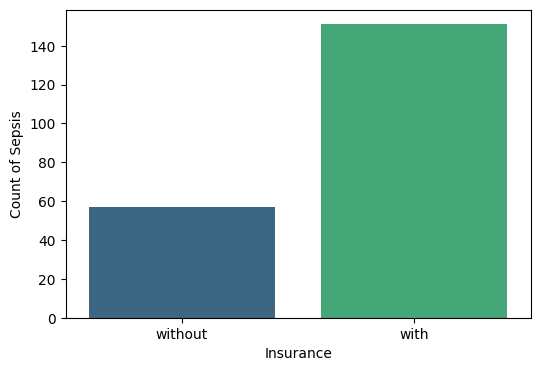

In [25]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df[mask_sepsis], x='Insurance', palette='viridis')
plt.xticks([0,1], ['without', 'with'])
plt.ylabel('Count of Sepsis')

plt.show()

Qn5. What is the average/median age of patients who develop sepsis and those without sepsis?

The avergae age of patients with sepsis 37 and the average age of patients without sepsis is 31


Text(0, 0.5, 'Average age')

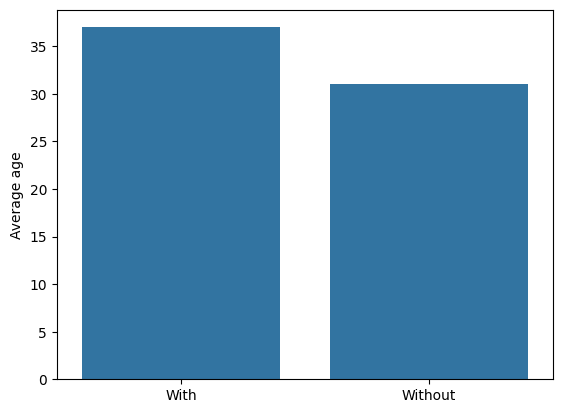

In [26]:
#Patients with sepsis
with_sepsis = train_df[train_df['Sepsis']=='Positive']

#Patients without sepsis
without_sepsis = train_df[train_df['Sepsis']=='Negative']

# calculate average age of patients with sepsis
average_age_with_sepsis = round(with_sepsis['Age'].mean())

# Calculate average age of patients without sepsis
average_age_without_sepsis = round(without_sepsis['Age'].mean())

print(f'The avergae age of patients with sepsis {average_age_with_sepsis} and the average age of patients without sepsis is {average_age_without_sepsis}')

sns.barplot(x=['With', 'Without'], y=[average_age_with_sepsis, average_age_without_sepsis])
plt.ylabel('Average age')


### Key Insights
1. The minimum age is 21 and the maximum age is 81
2. There are no missing values in the data set
3. The dataset conatins many outliers

## Data Preparation

Checking the dataset to find out if it is balanced

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepsis     599 non-null    object 
 11  Age_group  599 non-null    object 
dtypes: float64(2), int64(7), object(3)
memory usage: 56.3+ KB


In [28]:
sepsis_dist = train_df['Sepsis'].value_counts().rename('total').reset_index()
sepsis_dist

,Sepsis,total
0,Negative,391
1,Positive,208


In [29]:
sepsis_dist['ratio'] = sepsis_dist['total'].astype(object).apply(lambda X: round(X / sepsis_dist['total'].sum() * 100,2))
sepsis_dist

,Sepsis,total,ratio
0,Negative,391,65.28
1,Positive,208,34.72


In [30]:
# Dropping the ID column since we will not need it for modelling
train_df = train_df.drop(columns=['ID', 'Age_group'], axis=1)

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PRG        599 non-null    int64  
 1   PL         599 non-null    int64  
 2   PR         599 non-null    int64  
 3   SK         599 non-null    int64  
 4   TS         599 non-null    int64  
 5   M11        599 non-null    float64
 6   BD2        599 non-null    float64
 7   Age        599 non-null    int64  
 8   Insurance  599 non-null    int64  
 9   Sepsis     599 non-null    object 
dtypes: float64(2), int64(7), object(1)
memory usage: 46.9+ KB


#### Handling Outliers

In [32]:
def replace_outliers(train_df):
    numeric_cols = train_df.select_dtypes(include=['number']).columns
    for column in numeric_cols:
        Q1 = train_df[column].quantile(0.25)
        Q3 = train_df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        train_df[column] = train_df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    
    return train_df

In [33]:
# Replace outliers in all columns
train_df = replace_outliers(train_df)

In [34]:
train_df.head()

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepsis
0,6.0,148.0,72.0,35.0,0.0,33.6,0.6270,50.0,0,Positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.3510,31.0,0,Negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.6720,32.0,1,Positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.1670,21.0,1,Negative
4,0.0,137.0,40.0,35.0,168.0,43.1,1.2455,33.0,1,Positive


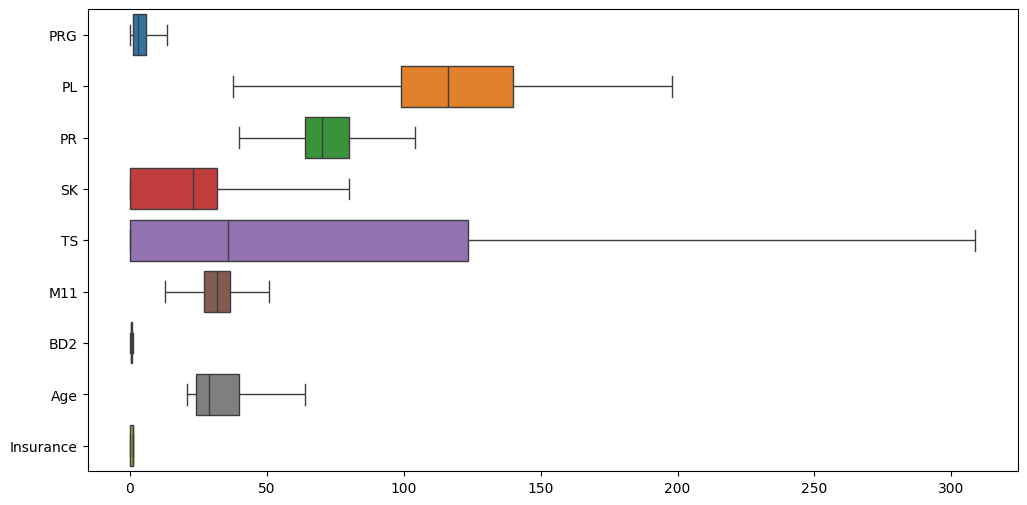

In [35]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df, orient='h')
plt.show()

Splitting the dataset into Training and Testing data
- X = Input variables
- y = Target variables

In [36]:
# Seperating the data into X and y variables
X = train_df.drop('Sepsis', axis =1)
y = train_df[['Sepsis']]

# Using the train_test_split to split my data into train and evaluation datasets
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size=0.8, random_state=0, stratify=y)

In [37]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train.values.ravel())
y_test_encoded = encoder.transform(y_test.values.ravel())

In [38]:
input_features = X.columns
input_features

Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='median'), input_features),
        ('scaler', StandardScaler(), input_features),
        ('log_transformations', FunctionTransformer(np.log1p), input_features)
    ]
)

## Modeling and Evaluation

In [40]:
# Create a list of models to use
models = [
    ('xgboost', XGBClassifier(random_state=42)),
    ('stochastic_gradient_descent', SGDClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('logistic_regression', LogisticRegression(random_state=42))
]


#### Training  the Imbalanced Dataset

In [41]:
#Create a table to store important metrics
results_table = pd.DataFrame(columns=["Model name", "Precision", "Recall", "Accuracy", "F1-Score"])
 
#initialize an empty dictionary to store pipelines
all_pipelines = {}
 
#Loop through the models to train and get the scores
for model_name, classifier in models:
 
    pipeline = Pipeline (steps=[
        ('preprocessor', preprocessor), 
        ('feature Importance', SelectKBest(mutual_info_classif, k='all')),
        ('classier', classifier),
    ])
 
    # Fit the traing data to the pipeline
    pipeline.fit(X_train, y_train_encoded)
    
    #Make prediction using the test or eval dataset
    y_pred = pipeline.predict(X_test)
    
    #Store classification report values as a dictionary
    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    #Save each individual pipleine in the loop to the initialised indictionary
    all_pipelines[model_name] = pipeline
    
    #Grab values from the balanced metric dictionary
    accuracy = metrics['accuracy'] 
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1 = metrics['weighted avg']['f1-score']

    #Add these values to the table
    results_table.loc[len(results_table)] = [model_name, precision, recall, accuracy, f1]
    
#sort table to have highest f1 on top
results_table.sort_values('F1-Score', ascending=False)

,Model name,Precision,Recall,Accuracy,F1-Score
0,xgboost,0.761508,0.766667,0.766667,0.762013
2,random_forest,0.746727,0.750000,0.750000,0.732216
3,logistic_regression,0.725000,0.733333,0.733333,0.717647
1,stochastic_gradient_descent,0.765368,0.575000,0.575000,0.559612


#### Training the Balanced Dataset  

In [42]:
# Create a list of models to use
balanced_models = [
    ('xgboost', XGBClassifier(random_state=42)),
    ('stochastic_gradient_descent', SGDClassifier(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42)),
    ('logistic_regression', LogisticRegression(random_state=42))
]

#Create a table to store important metrics
balanced_results_table = pd.DataFrame(columns=["Model name", "Precision", "Recall", "Accuracy", "F1-Score"])
 
#initialize an empty dictionary to store pipelines
balanced_pipelines = {}
 
#Loop through the models to train and get the scores
for model_name, classifier in balanced_models:
 
    balanced_pipeline = imbPipeline (steps=[
        ('preprocessor', preprocessor), 
        ('smote_sampler', SMOTE(sampling_strategy='auto', random_state=42)),
        ('feature Importance', SelectKBest(mutual_info_classif, k='all')),
        ('classifier', classifier),
    ])
 
    # Fit the traing data to the pipeline
    balanced_pipeline.fit(X_train, y_train_encoded)
    
    #Make prediction using the test or eval dataset
    y_pred = balanced_pipeline.predict(X_test)
    
    #Store classification report values as a dictionary
    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)
    
    #Save each individual pipleine in the loop to the initialised indictionary
    balanced_pipelines[model_name] = balanced_pipeline
    
    #Grab values from the balanced metric dictionary
    accuracy = metrics['accuracy'] 
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1 = metrics['weighted avg']['f1-score']

    #Add these values to the table
    balanced_results_table.loc[len(balanced_results_table)] = [model_name, precision, recall, accuracy, f1]
    
#sort table to have highest f1 on top
balanced_results_table.sort_values('F1-Score', ascending=False)


,Model name,Precision,Recall,Accuracy,F1-Score
2,random_forest,0.779545,0.783333,0.783333,0.775220
0,xgboost,0.753354,0.758333,0.758333,0.754438
3,logistic_regression,0.723541,0.725000,0.725000,0.724219
1,stochastic_gradient_descent,0.743750,0.650000,0.650000,0.654386


In [43]:
# balanced_pipelines

### Hyperparameter Tuning on the Balanced dataset

In [44]:

tuned_models_df = pd.DataFrame(columns=['Model name', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

tuned_pipelines = {}

# Define parameter grids for each model
param_grids = {
    'random_forest': {
        'classifier__n_estimators': [1, 20, 30], 
        'classifier__max_depth': [None, 10],
    },
    'stochastic_gradient_descent': {
        'classifier__alpha': [0.0001, 0.001, 0.01], 
        'classifier__loss': ['hinge', 'log_loss'],
    },
    'xgboost': {
        'classifier__n_estimators': [10, 20],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5],
    },
    'logistic_regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1],        
        'classifier__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'classifier__max_iter': [5, 10, 15, 20],

    }

}

# Perform Grid Search for each model

for model_name, pipeline in balanced_pipelines.items(): 
    param_grid = param_grids[model_name] 
    grid_search = GridSearchCV(pipeline, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_weighted') 
    grid_search.fit(X_train, y_train_encoded)

    #Update pipeline with best parameters
    best_pipeline = grid_search.best_estimator_ 
    tuned_pipelines[model_name] = best_pipeline

    #Make predictions with the tuned model
    y_pred = best_pipeline.predict(X_test)

    # Store classification report values as a dictionary
    tuned_metrics = classification_report(y_test_encoded, y_pred, output_dict=True)

    #Grab values from the balanced metric dictionary
    accuracy = tuned_metrics['accuracy']
    precision = tuned_metrics['weighted avg']['precision']
    recall  = tuned_metrics['weighted avg']['recall']
    f1 =  tuned_metrics['weighted avg']['f1-score']

    #Add these values to the table
    tuned_models_df.loc[len(tuned_models_df)] = [model_name, precision, recall, accuracy, f1]

#sort table to have highest f1 on top
tuned_models_df.sort_values(by='F1-Score', ascending=False)

,Model name,Accuracy,Precision,Recall,F1-Score
0,xgboost,0.815000,0.816667,0.816667,0.815591
2,random_forest,0.751985,0.758333,0.758333,0.750424
3,logistic_regression,0.746444,0.741667,0.741667,0.743588
1,stochastic_gradient_descent,0.709555,0.716667,0.716667,0.688494


In [45]:
balanced_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformations',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object'))])),
                ('smote_sampler', SMOTE(random_state=42)),
                ('feature Importance',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x00000211EAD09940>)),
                ('classifier', LogisticRegression(random_state=42))])

In [46]:
balanced_pipelines

{'xgboost': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('imputer',
                                                   SimpleImputer(strategy='median'),
                                                   Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                  ('scaler', StandardScaler(),
                                                   Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                  ('log_transformations',
                                                   FunctionTransformer(func=<ufun...
                                feature_types=None, gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                                max_bin=None, max_cat_threshold=None

### Visualizing the ROC_AUC Curve

stochastic_gradient_descent does not have predict_proba method and will be skipped.


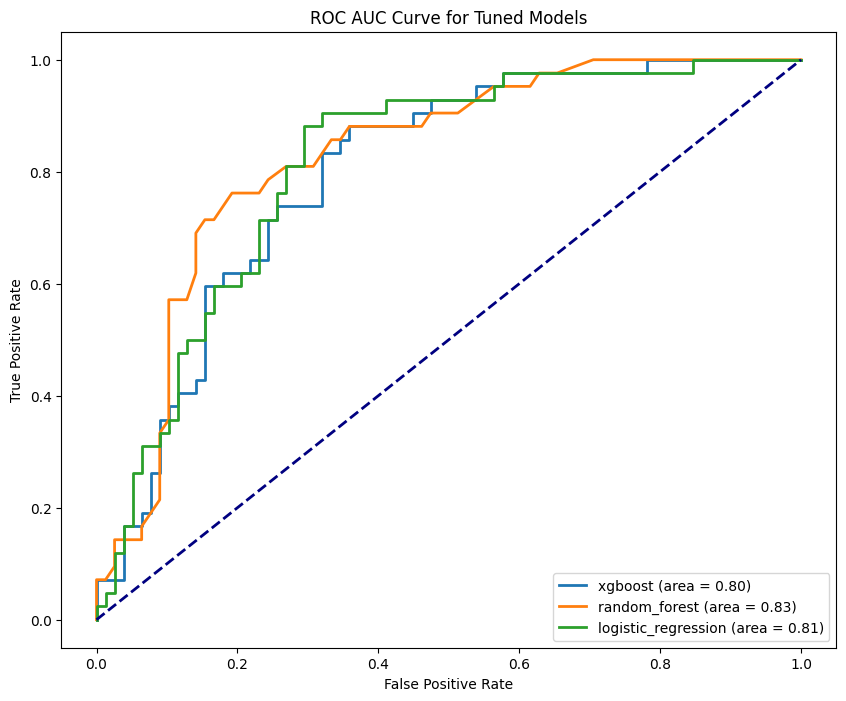

In [47]:
# Initialize a figure for the ROC AUC plots
plt.figure(figsize=(10, 8))

# Loop through each model and pipeline in the balanced_pipelines dictionary
for model_name, pipeline in balanced_pipelines.items():
    # Check if the classifier has the 'predict_proba' method
    if hasattr(pipeline.named_steps['classifier'], 'predict_proba'):
        # Make predictions with the tuned model and get the probabilities for the positive class
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and ROC area for each model
        fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')
    else:
        print(f'{model_name} does not have predict_proba method and will be skipped.')

# Plot diagonal line for reference (chance line)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Tuned Models')
plt.legend(loc="lower right")

# Show the plot
plt.show()


In [48]:
metric_before_after_tuning_models = pd.merge(
    balanced_results_table[['Model name', 'F1-Score']], 
    tuned_models_df[['Model name', 'F1-Score']], 
    left_on='Model name', 
    right_on='Model name', 
    how='inner', 
    suffixes=('_before', '_after')
).sort_values(ascending=False, by='F1-Score_after')

# Select only the Model Name and F1-Score columns before and after tuning
metric_before_after_tuning_models = metric_before_after_tuning_models[['Model name', 'F1-Score_before', 'F1-Score_after']]

# Display the results
metric_before_after_tuning_models


,Model name,F1-Score_before,F1-Score_after
0,xgboost,0.754438,0.815591
2,random_forest,0.775220,0.750424
3,logistic_regression,0.724219,0.743588
1,stochastic_gradient_descent,0.654386,0.688494


In [49]:
# Extract the best model based on the highest F1-Score after tuning
best_model_name = metric_before_after_tuning_models.iloc[0]['Model name']
best_model_pipeline = balanced_pipelines[best_model_name]

# Display the best model's name and pipeline
print(f"The best model is: {best_model_name}")
best_model_pipeline


The best model is: xgboost


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('imputer',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance'], dtype='object')),
                                                 ('log_transformations',
                                                  FunctionTransformer(func=<ufun...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

#### Predictions on Test Dataset Using Best-Performing Model

In [50]:
# Loading the test Data into the notebook using pandas
test_df = pd.read_csv("../Data/Paitients_Files_Test.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         169 non-null    object 
 1   PRG        169 non-null    int64  
 2   PL         169 non-null    int64  
 3   PR         169 non-null    int64  
 4   SK         169 non-null    int64  
 5   TS         169 non-null    int64  
 6   M11        169 non-null    float64
 7   BD2        169 non-null    float64
 8   Age        169 non-null    int64  
 9   Insurance  169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


In [51]:
test_df.drop("ID", axis=1, inplace=True)

In [52]:
predicted_sepsis = best_model_pipeline.predict(test_df)

predicted_sepsis

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

#### Saving the Models

In [53]:
for model_name, pipeline in tuned_pipelines.items():
    joblib.dump(pipeline,f'../models/{model_name}.joblib')

    joblib.dump(encoder,f'../models/encoder.joblib')

# Thank you